In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import PIL
import PIL.Image
import sklearn.metrics as sklm
import tensorflow as tf

tf.__version__

'2.5.0'

In [2]:
import sys
print(sys.version)
print(sys.executable)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
C:\Users\halou\anaconda3\python.exe


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
batch_size = 32
img_height = 512
img_width = 200

## Preprocessing Dataset

In [5]:
import pathlib

train_dir = pathlib.Path("datasets/train")
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

540


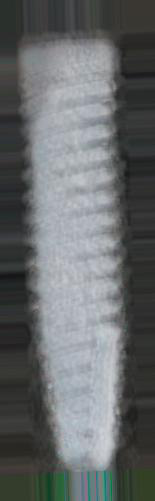

In [6]:
alvim = list(train_dir.glob('Alvim/*'))
PIL.Image.open(str(alvim[0]))

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels='inferred', label_mode='int',
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 540 files belonging to 3 classes.
Using 405 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Alvim', 'Drive', 'Helix']


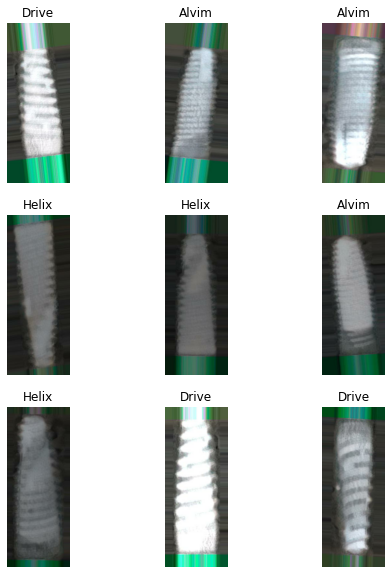

In [9]:
plt.figure(figsize=(8, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels='inferred', label_mode='int',
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 540 files belonging to 3 classes.
Using 135 files for validation.


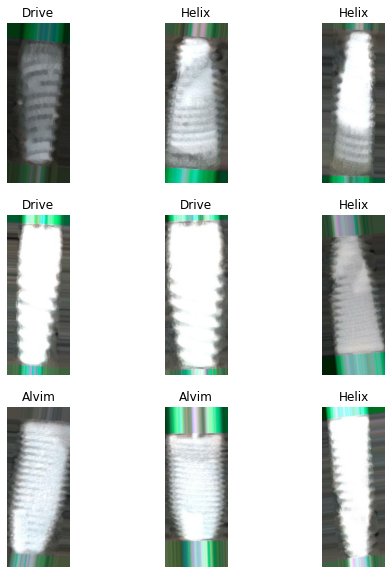

In [11]:
plt.figure(figsize=(8, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

print(y_test)

[2 0 2 1 1 1 0 2 1 0 1 0 0 1 0 1 0 1 1 1 1 1 2 2 0 0 1 0 1 2 1 0 1 0 1 2 2
 0 2 0 0 0 2 1 1 2 2 1 2 1 0 2 0 0 0 2 1 2 0 2 0 0 2 2 0 1 2 0 1 1 0 1 1 2
 2 1 1 1 0 1 0 0 1 2 0 1 2 1 1 0 1 2 0 1 2 2 0 2 2 1 1 2 1 2 2 0 0 0 2 0 0
 0 0 0 2 1 1 2 2 1 0 0 2 2 2 1 1 0 1 1 1 2 1 0 1]


In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 512, 200, 3)
(32,)


## Modeling the CNN

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 3
dropout_rate = 0.25

model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, 3, activation='relu'))
model.add(layers.Conv2D(16, 3, activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 198, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 196, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 508, 196, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 254, 98, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 96, 32)       4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 250, 94, 32)       9

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(
    train_ds,
    epochs=20,      
    validation_data=test_ds
)

Epoch 1/20
13/13 [==============================] - 14s 438ms/step - loss: 1.5435 - accuracy: 0.3037 - val_loss: 3.9648 - val_accuracy: 0.3704
Epoch 2/20
13/13 [==============================] - 2s 165ms/step - loss: 1.0685 - accuracy: 0.4370 - val_loss: 2.2155 - val_accuracy: 0.2963
Epoch 3/20
13/13 [==============================] - 2s 164ms/step - loss: 0.9603 - accuracy: 0.5284 - val_loss: 1.4221 - val_accuracy: 0.3778
Epoch 4/20
13/13 [==============================] - 2s 164ms/step - loss: 0.8945 - accuracy: 0.5926 - val_loss: 1.0647 - val_accuracy: 0.4667
Epoch 5/20
13/13 [==============================] - 2s 164ms/step - loss: 0.8198 - accuracy: 0.6543 - val_loss: 1.1598 - val_accuracy: 0.4593
Epoch 6/20
13/13 [==============================] - 2s 164ms/step - loss: 0.7883 - accuracy: 0.6790 - val_loss: 1.7860 - val_accuracy: 0.3333
Epoch 7/20
13/13 [==============================] - 2s 163ms/step - loss: 0.7296 - accuracy: 0.6840 - val_loss: 2.6382 - val_accuracy: 0.3333
Epoch

5/5 - 0s - loss: 0.7274 - accuracy: 0.6370


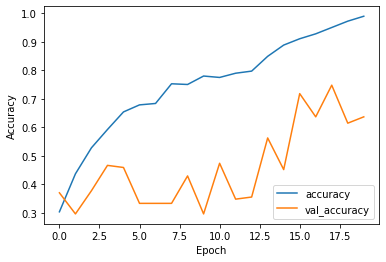

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


test_loss, test_acc = model.evaluate(test_ds, verbose=2)

## Confusion Matrix

In [19]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    "datasets/test",
    target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

Found 105 images belonging to 3 classes.


In [20]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = sklm.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       Alvim       0.25      0.04      0.07        23
       Drive       0.00      0.00      0.00        37
       Helix       0.44      0.98      0.60        45

    accuracy                           0.43       105
   macro avg       0.23      0.34      0.23       105
weighted avg       0.24      0.43      0.27       105



C:\Users\halou\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
